In [1]:
%%capture
!pip install datasets
#!pip install transformers==4.11.3
!pip install librosa
!pip install wandb

!pip install transformers[torch]
!pip install accelerate -U

In [2]:
#model_checkpoint = "facebook/wav2vec2-base"
# model_checkpoint = "facebook/wav2vec2-xls-r-300m"
# batch_size = 4

root_folder = "gdrive/MyDrive/emotion_recognition/"
data_path = root_folder + "data_init/"
data_seg_path = root_folder + "data_init_segments/"
res_folder = root_folder + 'experiments/'

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
from datasets import Dataset, load_metric
import wandb
import time
import pandas as pd

In [5]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from matplotlib import pyplot as plt

def evaluate(y_true, y_pred, run, display_cm=True, display_cr=True):
    # print(f"f1-score: {round(f1_score(y_true, y_pred, average='binary'),2)}, accuracy: {round(accuracy_score(y_true, y_pred),2)}")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    if display_cm:
      disp = ConfusionMatrixDisplay(confusion_matrix=cm)
      disp.plot()
      plt.show()

    if display_cr:
      cr = classification_report(y_true, y_pred, target_names=['no_conflict', 'conflict'])
      print(cr)

    if run:
      wandb.sklearn.plot_confusion_matrix(y_true, y_pred, ['no_conflict', 'conflict'])

      cr = classification_report(y_true, y_pred, target_names=['no_conflict', 'conflict'], output_dict=True)
      run.log({"accuracy" : cr['accuracy'],
              "no_conflict_precision" : cr['no_conflict']['precision'],
              "no_conflict_recall" : cr['no_conflict']['recall'],
              "no_conflict_f1-score" : cr['no_conflict']['f1-score'],
              "conflict_precision" : cr['conflict']['precision'],
              "conflict_recall" : cr['conflict']['recall'],
              "conflict_f1-score" : cr['conflict']['f1-score']})

In [6]:
import numpy as np

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

<ipython-input-6-56905cb731e6>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [26]:
# 48th is empty
df_seg = pd.read_csv(data_seg_path+'seg_info.csv').drop([48]).reset_index()

In [27]:
df_seg['emotion'].unique()

array(['neutral', 'disgust', 'sad', 'happy', 'angry', 'pleasant_surprise'],
      dtype=object)

In [28]:
df_seg['emotion_split'] = df_seg['emotion']
df_seg.loc[df_seg['emotion_split'] == 'pleasant_surprise', 'emotion_split'] = 'happy'
df_seg.loc[df_seg['emotion_split'] == 'disgust', 'emotion_split'] = 'angry'

In [30]:
(df_seg['speech_duration'] > 20).sum()

30

<Axes: xlabel='emotion_split'>

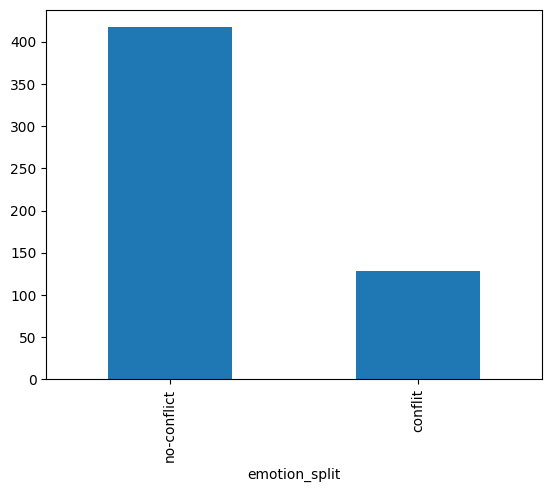

In [31]:

df_seg['emotion_split'] = df_seg['emotion_split'].apply(lambda x: 'no-conflict' if x in ['neutral', 'happy'] else 'conflit')
df_seg['emotion_split'].value_counts().plot(kind = 'bar')

In [32]:
def change_lang(lang, langid_lang):
  if lang == 's':
    if langid_lang == 'ru':
      return 'r'
    return 'u'
  return lang


df_seg['language'] = df_seg.apply(lambda row: change_lang(row['language'], row['langid_language']),
                                  axis=1)

df_seg['emotion_split_lang'] = df_seg.apply(lambda row: row['emotion_split'] + '_' + row['language'], axis=1)


<Axes: xlabel='emotion_split'>

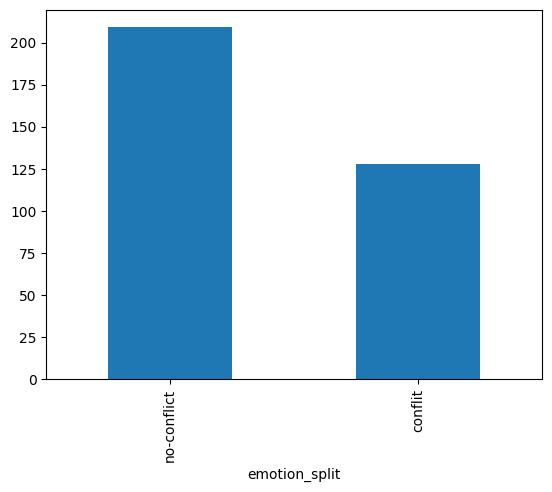

In [34]:
df_seg = df_seg.drop(df_seg[df_seg['emotion_split'] == 'no-conflict'].sample(frac=.5).index)
df_seg['emotion_split'].value_counts().plot(kind = 'bar')

<Axes: xlabel='emotion_split_lang'>

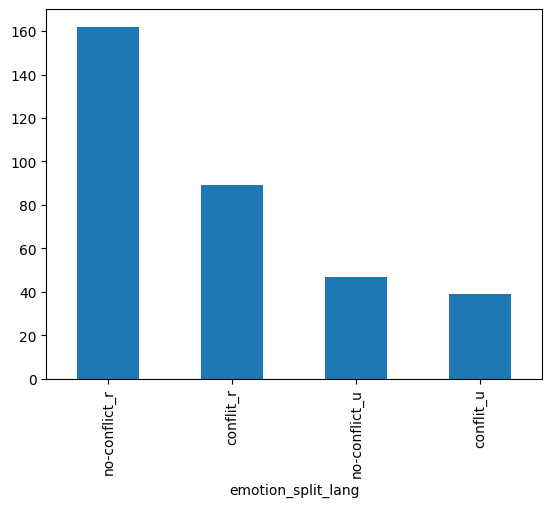

In [35]:
df_seg['emotion_split_lang'].value_counts().plot(kind = 'bar')

In [36]:
df_seg[['emotion_split_lang', 'speech_duration']].groupby(['emotion_split_lang']).mean()

,speech_duration
emotion_split_lang,
conflit_r,10.579453
conflit_u,8.238680
no-conflict_r,5.491817
no-conflict_u,5.560026


In [37]:
df_seg[['emotion_split', 'language', 'speech_duration']].groupby(['emotion_split', 'language']).mean().reset_index()

,emotion_split,language,speech_duration
0,conflit,r,10.579453
1,conflit,u,8.238680
2,no-conflict,r,5.491817
3,no-conflict,u,5.560026


In [38]:
df_seg[['emotion_split', 'language', 'speech_duration']].groupby(['emotion_split', 'language']).sum() / 60

speech_duration
emotion_split language                 
conflit       r               15.692855
              u                5.355142
no-conflict   r               14.827905
              u                4.355354

<Figure size 1000x600 with 0 Axes>

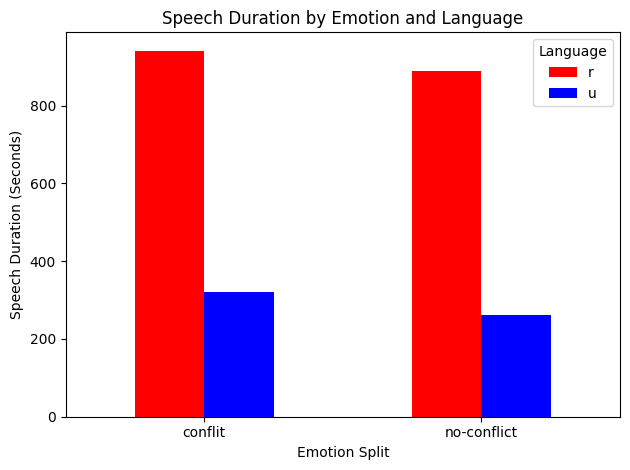

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
bar_cont = df_seg.groupby(['emotion_split', 'language'])['speech_duration'].sum().unstack()
bar_cont.plot(kind='bar', color=['red', 'blue'])
plt.xlabel("Emotion Split")
plt.ylabel("Speech Duration (Seconds)")
plt.title("Speech Duration by Emotion and Language")
plt.legend(title="Language")
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

<Figure size 1000x600 with 0 Axes>

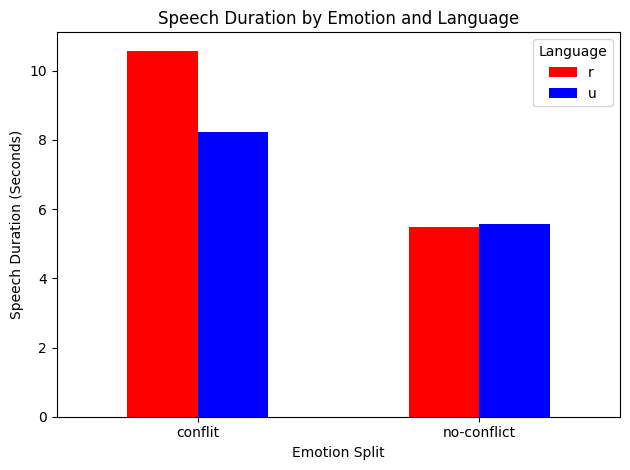

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
bar_cont = df_seg.groupby(['emotion_split', 'language'])['speech_duration'].mean().unstack()
bar_cont.plot(kind='bar', color=['red', 'blue'])
plt.xlabel("Emotion Split")
plt.ylabel("Speech Duration (Seconds)")
plt.title("Speech Duration by Emotion and Language")
plt.legend(title="Language")
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

In [41]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_seg, test_size=0.3, random_state=0, stratify=df_seg[['emotion_split_lang']])


In [42]:
train_df[['emotion_split', 'language', 'speech_duration']].groupby(['emotion_split', 'language']).sum()['speech_duration'].sum() / 60

27.435793316666665

In [43]:
test_df[['emotion_split', 'language', 'speech_duration']].groupby(['emotion_split', 'language']).sum()['speech_duration'].sum() / 60

12.795463566666667

In [47]:
# Prepare dataset features
dataset_dict = {
    "train": {
        "audio": (train_df['folder_name'] + train_df['res_file_name']).tolist(),
        "audio_path": (train_df['folder_name'] + train_df['res_file_name']).tolist(),
        "seg_meta_idx" : train_df['index'].tolist(),
        "label": train_df['emotion_split'].tolist()
    },
    "test": {
        "audio": test_df['folder_name'] + test_df['res_file_name'],
        "audio_path": test_df['folder_name'] + test_df['res_file_name'],
        "seg_meta_idx" : test_df['index'].tolist(),
        "label": test_df['emotion_split'].tolist()
    }
}

In [48]:
labels = df_seg['emotion_split'].unique()
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [49]:
dataset_train_dict = {
        "audio": (train_df['folder_name'] + train_df['res_file_name']).tolist(),
        "audio_path": (train_df['folder_name'] + train_df['res_file_name']).tolist(),
        "seg_meta_idx" : train_df['index'].tolist(),
        "label": train_df['emotion_split'].apply(lambda x: int(label2id[x])).tolist()
}

dataset_test_dict = {
        "audio": test_df['folder_name'] + test_df['res_file_name'],
        "audio_path": test_df['folder_name'] + test_df['res_file_name'],
        "seg_meta_idx" : test_df['index'].tolist(),
        "label": test_df['emotion_split'].apply(lambda x: int(label2id[x])).tolist()
}

In [50]:
from datasets import Dataset, Audio

train_dataset = Dataset.from_dict(dataset_train_dict).cast_column("audio", Audio(sampling_rate=16000))
test_dataset = Dataset.from_dict(dataset_test_dict).cast_column("audio", Audio(sampling_rate=16000))

https://colab.research.google.com/github/huggingface/notebooks/blob/master/examples/audio_classification.ipynb#scrollTo=wX35xSLx-ghC

In [65]:
model_checkpoint = "facebook/wav2vec2-xls-r-300m"
# model_checkpoint = "facebook/wav2vec2-xls-r-1b"

max_duration = 20

In [66]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
feature_extractor

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0,
  "return_attention_mask": true,
  "sampling_rate": 16000
}

In [67]:
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=int(feature_extractor.sampling_rate * max_duration),
        truncation=True,
    )
    return inputs

In [68]:
# preprocess_function(train_dataset[:1])

In [69]:
encoded_test_dataset = test_dataset.map(preprocess_function, remove_columns=["audio", "audio_path", "seg_meta_idx"], batched=True)
encoded_train_dataset = train_dataset.map(preprocess_function, remove_columns=["audio", "audio_path", "seg_meta_idx"], batched=True)


Map:   0%|          | 0/102 [00:00<?, ? examples/s]

Map:   0%|          | 0/235 [00:00<?, ? examples/s]

In [70]:
encoded_test_dataset

Dataset({
    features: ['label', 'input_values', 'attention_mask'],
    num_rows: 102
})

In [71]:
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer

num_labels = len(id2label)
model = AutoModelForAudioClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label,
)


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-xls-r-1b and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [72]:
model.freeze_feature_extractor()

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:2046: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5. Please use the equivalent `freeze_feature_encoder` method instead.
  warnings.warn(


In [60]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [73]:
from torch import cuda

learning_rate = 5e-6
warmup_ratio=0.1
num_train_epochs=1
batch_size=1
gradient_accumulation_steps=4

device = "cuda:0" if cuda.is_available() else "cpu"


config = {
    "model_name" : model_checkpoint,
    "fine-tuned" : True,
    "dowstream_model" : "auto",
    "framework" : "HF",
    "data" : "init_neutral_cut_1h",
    "lang" : "auto",
    "max_duration" : max_duration,
    "batch_size" : batch_size,
    "device" : device,
    "chunking" : "no",
    "learning_rate" : learning_rate,
    "warmup_ratio" : warmup_ratio,
    "num_train_epochs" : num_train_epochs,
    "gradient_accumulation_steps" : gradient_accumulation_steps,
    "freeze" : "feature_extractor"
}


timestr = time.strftime("%m%d-%H%M")
run = wandb.init(project="emotion_recognition",
            name=f"e_{timestr}_w2v2_finetune",
            config=config)

model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-ser-mixed",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    warmup_ratio=warmup_ratio,
    logging_steps=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    report_to = 'wandb',  # enable logging to W&B
)

trainer = Trainer(
    model,
    args,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_test_dataset,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)

OutOfMemoryError: CUDA out of memory. Tried to allocate 50.00 MiB. GPU 0 has a total capacity of 22.17 GiB of which 2.88 MiB is free. Process 12797 has 22.16 GiB memory in use. Of the allocated memory 20.98 GiB is allocated by PyTorch, and 945.63 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
trainer.train()

In [261]:
trainer.evaluate()

{'eval_loss': 0.6943616271018982,
 'eval_accuracy': 0.4074074074074074,
 'eval_runtime': 3.7714,
 'eval_samples_per_second': 7.159,
 'eval_steps_per_second': 1.856,
 'epoch': 5.0}

[[15  0]
 [12  0]]


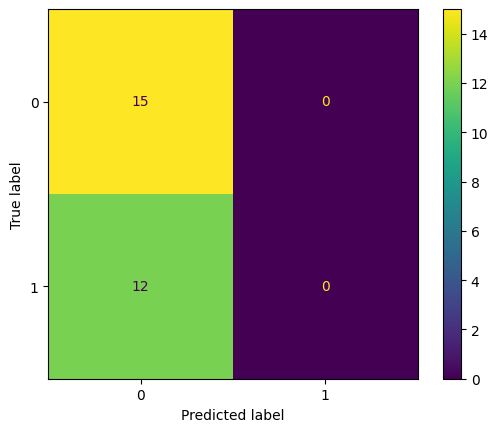

              precision    recall  f1-score   support

 no_conflict       0.56      1.00      0.71        15
    conflict       0.00      0.00      0.00        12

    accuracy                           0.56        27
   macro avg       0.28      0.50      0.36        27
weighted avg       0.31      0.56      0.40        27



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
eval/accuracy,▁▁▁▁▁▁
eval/loss,█▆▄▁▁█
eval/runtime,▃▁▂▂▃█
eval/samples_per_second,▆█▇▇▆▁
eval/steps_per_second,▆█▇▇▆▁
no_conflict_f1-score,▁
no_conflict_precision,▁


In [255]:
eval_pred = trainer.predict(test_dataset=encoded_test_dataset)
evaluate(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=1), run)
wandb.finish()

In [198]:
wandb.finish()

In [199]:
eval_pred = trainer.predict(test_dataset=encoded_test_dataset)

In [ ]:
references=eval_pred.label_ids

In [ ]:
references

In [ ]:
predictions

In [ ]:
id2label['2']

In [ ]:
trainer.save_model(res_folder + 'model-300m-4-10-acc-56')

300m:

*   batch size: 4
*   max_duration: 8
*   whole training


	text/plain
		{'eval_loss': 1.2309445142745972,
		 'eval_accuracy': 0.5058823529411764,
		 'eval_runtime': 126.2105,
		 'eval_samples_per_second': 0.673,
		 'eval_steps_per_second': 0.174,
		 'epoch': 4.8}




In [ ]:
# trainer.evaluate()

In [ ]:
# trainer.save_model(res_folder + 'model-300m')